In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [2]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_332\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

In [6]:
df = df.loc[(df['doc_aula_req']!=0) | (df['doc_aula_exd_n']+df['doc_aula_exd_c']!=0)]

# Data for clusters
Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [7]:
df['d_niv_mod'].value_counts()

Primaria                 22650
Inicial - Jardin         10388
Inicial - Cuna-jardin      251
Name: d_niv_mod, dtype: int64

In [8]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

## Primary level

In [9]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [10]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

### Missing

In [11]:
df_primaria[['nlat_ie','nlong_ie']].isnull().sum()

nlat_ie     0
nlong_ie    0
dtype: int64

In [12]:
df_primaria[str_primaria].isnull().sum()

d_prov            0
d_dreugel         0
region            0
ruralidad         0
vraem             0
frontera          0
bilingue          0
caracteristica    0
dtype: int64

<AxesSubplot:ylabel='cod_mod-year'>

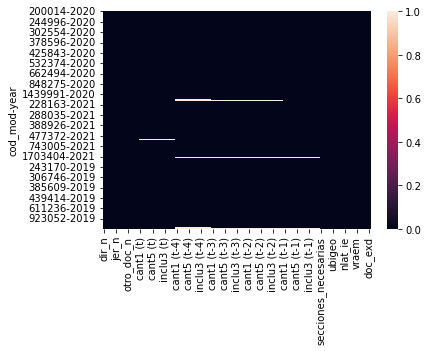

In [13]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

In [14]:
# Imputing missing
df_primaria.fillna(0,inplace=True)

### Feature selection

#### Build total labor force and growth enrollment

In [15]:
# Labor force
df_primaria['Directores'] = df_primaria['dir_n'] + df_primaria['dir_c']
df_primaria['Subdirectores'] = df_primaria['sub_dir_n'] + df_primaria['sub_dir_c']
df_primaria['Jerarquicos'] = df_primaria['jer_n'] + df_primaria['jer_c']
df_primaria['Docentes de aula'] = df_primaria['doc_aula_n'] + df_primaria['doc_aula_c']
df_primaria['Otros docentes'] = df_primaria['otro_doc_n'] + df_primaria['otro_doc_c']
df_primaria['Auxiliares'] = df_primaria['aux_n'] + df_primaria['aux_c']
personal = ['Directores','Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

In [16]:
# Enrollment
periodos = ['t','t-1','t-2','t-3','t-4']
# Total Enrollment
for i in periodos:
    df_primaria[f'Matricula regular total {i}']=df_primaria[f'cant1 ({i})']+df_primaria[f'cant2 ({i})']+df_primaria[f'cant3 ({i})']+df_primaria[f'cant4 ({i})']+df_primaria[f'cant5 ({i})']+df_primaria[f'cant6 ({i})']
    df_primaria[f'Matricula inclusiva total {i}']=df_primaria[f'inclu1 ({i})']+df_primaria[f'inclu2 ({i})']+df_primaria[f'inclu3 ({i})']+df_primaria[f'inclu4 ({i})']+df_primaria[f'inclu5 ({i})']+df_primaria[f'inclu6 ({i})']

# Growth rate enrollment
# Method 1
#df_primaria["tasa_c_anual_regular"]=((df_primaria['Matricula regular total t']/df_primaria['Matricula regular total t-4'])**(1/4))-1
#df_primaria["tasa_c_anual_inclusivo"]=((df_primaria['Matricula inclusiva total t']/df_primaria['Matricula inclusiva total t-4'])**(1/4))-1
# Method 2
df_primaria['tasa_c_anual_regular'] = ((df_primaria['Matricula regular total t']+df_primaria['Matricula regular total t-1'])+
                                        (df_primaria['Matricula regular total t-1']+df_primaria['Matricula regular total t-2'])+
                                        (df_primaria['Matricula regular total t-3']+df_primaria['Matricula regular total t-4']))/3

#### Scaling the input features

In [17]:
# Drop no relevant information for encoding
df_primaria.drop(columns=['d_prov','d_dreugel','region','caracteristica'],inplace=True)

In [18]:
# Requerimiento
primaria_req = df_primaria.loc[df_primaria['doc_aula_req']!=0]
primaria_req.drop(columns=['doc_exd'], inplace=True)
# Excedentes
primaria_exd = df_primaria.loc[df_primaria['doc_exd']!=0]
primaria_exd.drop(columns=['doc_aula_req'], inplace=True)

In [19]:
num_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype!='object']
num_req = [x for x in primaria_req.columns if primaria_req[x].dtype!='object']

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

primaria_exd_scaled = pd.DataFrame(scaler.fit_transform(primaria_exd[num_exd].values), columns=primaria_exd[num_exd].columns, index=primaria_exd[num_exd].index)
primaria_req_scaled = pd.DataFrame(scaler.fit_transform(primaria_req[num_req].values), columns=primaria_req[num_req].columns, index=primaria_req[num_req].index)

#### Encoding categorical variable

In [41]:
str_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype=='object']
str_req = [x for x in primaria_req.columns if primaria_req[x].dtype=='object']

In [ ]:
def encoding_str(df, new_df,list_str):

In [51]:
oh_prim_exd = pd.get_dummies(primaria_req[str_exd])

In [39]:
# Enconding string variables
oh_primaria = pd.get_dummies(df_primaria)
# Drop no relevant information
oh_primaria.drop(columns=['frontera_No frontera', 'bilingue_No bilingue','vraem_No Vraem','ruralidad_Urbano','aux_exd','aux_req','jer_n','aux_n','aux_c',
                        'dir_n','dir_c','sub_dir_n','sub_dir_c', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c'],inplace=True)

In [40]:
oh_primaria

,,cant1 (t),cant2 (t),cant3 (t),cant4 (t),cant5 (t),cant6 (t),inclu1 (t),inclu2 (t),inclu3 (t),inclu4 (t),...,Matricula inclusiva total t-3,Matricula regular total t-4,Matricula inclusiva total t-4,tasa_c_anual_regular,ruralidad_Rural 1,ruralidad_Rural 2,ruralidad_Rural 3,vraem_Vraem,frontera_Frontera,bilingue_Bilingue
cod_mod,year,,,,,,,,,,,,,,,,,,,,,
200014,2020,2.0,2.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,29.0,1.0,33.666667,0,1,0,0,0,1
200048,2020,1.0,2.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,21.333333,0,1,0,0,0,1
200089,2020,5.0,5.0,9.0,7.0,10.0,8.0,0.0,0.0,0.0,0.0,...,0.0,54.0,0.0,95.666667,0,1,0,0,0,1
200105,2020,3.0,8.0,3.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,...,0.0,37.0,0.0,64.000000,0,1,0,0,0,1
200121,2020,7.0,9.0,7.0,11.0,9.0,11.0,0.0,1.0,1.0,0.0,...,1.0,53.0,0.0,106.333333,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779610,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0,0,0,0,0,0
1779628,2019,3.0,2.0,3.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.333333,0,0,0,0,0,0
1779651,2019,7.0,6.0,6.0,9.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.666667,0,0,0,0,0,0


### Finding optimal clusters

#### requirements

In [42]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [45]:
primaria_req_knn = primaria_req_scaled.copy()

TypeError: 'bool' object is not callable

In [44]:
## Vamos a hacer el grafico del codo. Para esto vamos a probar hacer distintos clusters y vamos a guardar el error (que lo definimos como wcss)
# WCSS --> Wihin Cluster Sum of Squares
wcss = []
for i in range(1,12):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=36963)
  kmeans.fit(primaria_req_knn)
  wcss.append(kmeans.inertia_)

TypeError: float() argument must be a string or a number, not 'MinMaxScaler'

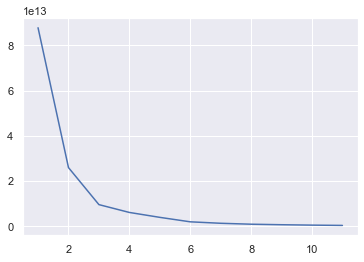

In [115]:
import matplotlib.pyplot as plt
sns.set()
plt.plot(range(1,12),wcss)

In [116]:
## El numero optimo de clusters es igual a 6, asi que haremos 6 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=36963)
kmeans.fit(primaria_req_knn)
clusters = kmeans.predict(primaria_req_knn)

In [117]:
primaria_req_knn['Segmento'] = clusters

### Inspecting clusters

In [118]:
for i in range(6):
    print(f'Cluster {i}')
    print(primaria_req_knn.loc[primaria_req_knn['Segmento']==i, ['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']].describe().transpose())
    print('\n')

Cluster 0
                   count      mean       std  min  25%  50%  75%   max
Directores        1638.0  0.294261  0.455849  0.0  0.0  0.0  1.0   1.0
Subdirectores     1638.0  0.060440  0.293502  0.0  0.0  0.0  0.0   3.0
Jerarquicos       1638.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Docentes de aula  1638.0  4.176435  6.007937  0.0  1.0  2.0  4.0  56.0
Otros docentes    1638.0  0.413309  1.034880  0.0  0.0  0.0  0.0  10.0
Auxiliares        1638.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0


Cluster 1
                   count      mean       std  min  25%  50%  75%   max
Directores        2318.0  0.197584  0.400424  0.0  0.0  0.0  0.0   2.0
Subdirectores     2318.0  0.094047  0.337229  0.0  0.0  0.0  0.0   4.0
Jerarquicos       2318.0  0.000431  0.020770  0.0  0.0  0.0  0.0   1.0
Docentes de aula  2318.0  5.169543  7.661155  0.0  1.0  2.0  5.0  70.0
Otros docentes    2318.0  0.490509  1.164370  0.0  0.0  0.0  0.0   9.0
Auxiliares        2318.0  0.000000  0.000000  0.0  0.0 

In [119]:
enroll = ['Matricula regular total t', 'Matricula inclusiva total t',
            'Matricula regular total t-1','Matricula inclusiva total t-1',
            'Matricula regular total t-2','Matricula inclusiva total t-2',
            'Matricula regular total t-3','Matricula inclusiva total t-3',
            'Matricula regular total t-4','Matricula inclusiva total t-4',
            'tasa_c_anual_regular']

for i in range(6):
    print(f'Cluster {i}')
    print(primaria_req_knn.loc[primaria_req_knn['Segmento']==i, enroll].describe().transpose())
    print('\n')

Cluster 0
                                count        mean         std  min   25%  \
Matricula regular total t      1638.0  113.723443  189.248166  0.0  29.0   
Matricula inclusiva total t    1638.0    0.960317    2.432274  0.0   0.0   
Matricula regular total t-1    1638.0  104.629426  178.758715  0.0  25.0   
Matricula inclusiva total t-1  1638.0    1.195971    2.596470  0.0   0.0   
Matricula regular total t-2    1638.0   97.836386  169.724057  0.0  24.0   
Matricula inclusiva total t-2  1638.0    1.238095    2.553178  0.0   0.0   
Matricula regular total t-3    1638.0   94.645299  165.130501  0.0  23.0   
Matricula inclusiva total t-3  1638.0    1.299756    2.682305  0.0   0.0   
Matricula regular total t-4    1638.0   92.294261  161.226386  0.0  22.0   
Matricula inclusiva total t-4  1638.0    1.286935    2.609032  0.0   0.0   
tasa_c_anual_regular           1638.0  202.586081  346.232629  0.0  49.0   

                                     50%     75%          max  
Matricula reg

In [120]:
for i in range(6):
    print(f'Cluster {i}')
    print(primaria_req_knn.loc[primaria_req_knn['Segmento']==i, ['ruralidad_Rural 1','ruralidad_Rural 2','ruralidad_Rural 3','vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue']].describe().transpose())
    print('\n')

Cluster 0
                    count      mean       std  min  25%  50%  75%  max
ruralidad_Rural 1  1638.0  0.518926  0.499794  0.0  0.0  1.0  1.0  1.0
ruralidad_Rural 2  1638.0  0.231990  0.422232  0.0  0.0  0.0  0.0  1.0
ruralidad_Rural 3  1638.0  0.054335  0.226746  0.0  0.0  0.0  0.0  1.0
vraem_Vraem        1638.0  0.099512  0.299439  0.0  0.0  0.0  0.0  1.0
frontera_Frontera  1638.0  0.057998  0.233810  0.0  0.0  0.0  0.0  1.0
bilingue_Bilingue  1638.0  0.161172  0.367802  0.0  0.0  0.0  0.0  1.0


Cluster 1
                    count      mean       std  min  25%  50%  75%  max
ruralidad_Rural 1  2318.0  0.557808  0.496754  0.0  0.0  1.0  1.0  1.0
ruralidad_Rural 2  2318.0  0.141501  0.348613  0.0  0.0  0.0  0.0  1.0
ruralidad_Rural 3  2318.0  0.055651  0.229297  0.0  0.0  0.0  0.0  1.0
vraem_Vraem        2318.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
frontera_Frontera  2318.0  0.161777  0.368326  0.0  0.0  0.0  0.0  1.0
bilingue_Bilingue  2318.0  0.210526  0.407770  0.0  0.0

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


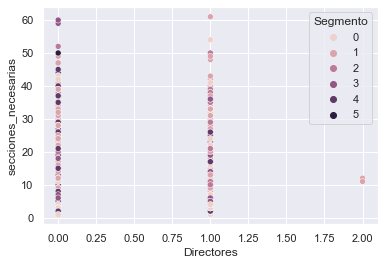

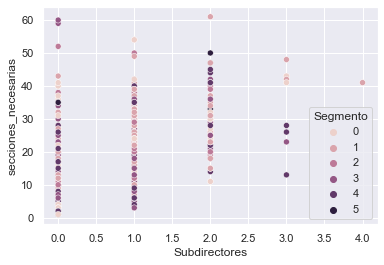

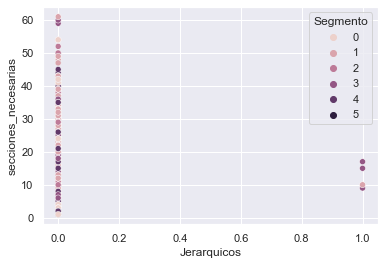

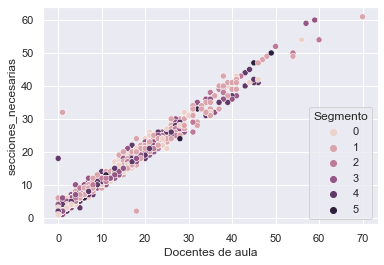

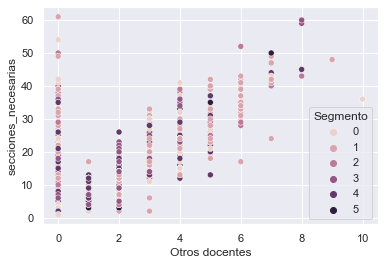

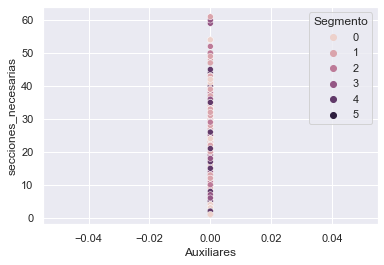

<Figure size 432x288 with 0 Axes>

In [79]:
import matplotlib.pyplot as plt

for i in ['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']:
    print(sns.scatterplot(x=f'{i}', y="secciones_necesarias", hue="Segmento",data=primaria_req_knn))
    plt.figure()

In [ ]:
for i in ['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']:
    print(sns.scatterplot(x=f'{i}', y="doc_aula_req", hue="Segmento",data=primaria_req_knn))
    plt.figure()

In [ ]:
['dir_n','dir_c','sub_dir_n','sub_dir_c', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c']
['secciones_necesarias','doc_aula_req']
['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

['Matricula regular total t', 'Matricula inclusiva total t',
 'Matricula regular total t-1','Matricula inclusiva total t-1',
 'Matricula regular total t-2','Matricula inclusiva total t-2',
 'Matricula regular total t-3','Matricula inclusiva total t-3',
 'Matricula regular total t-4','Matricula inclusiva total t-4',
 'tasa_c_anual_regular']

['ruralidad_Rural 1','ruralidad_Rural 2','ruralidad_Rural 3','vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue']

<AxesSubplot:xlabel='secciones_necesarias', ylabel='doc_aula_req'>

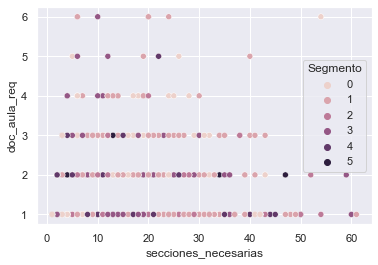

In [78]:
sns.scatterplot(x="secciones_necesarias", y="doc_aula_req", hue="Segmento",data=primaria_req_knn)

<AxesSubplot:xlabel='tasa_c_anual_regular', ylabel='doc_exd'>

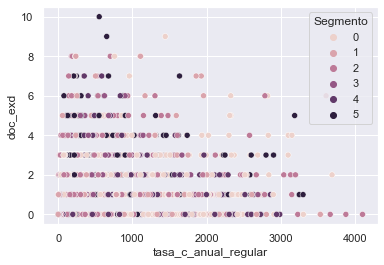

In [45]:
sns.scatterplot(x="tasa_c_anual_regular", y="doc_exd", hue="Segmento",data=df_primaria_knn)

In [51]:
df_primaria_knn['aux_exd'].value_counts()

0.0    22650
Name: aux_exd, dtype: int64

<AxesSubplot:xlabel='aux_req', ylabel='doc_exd'>

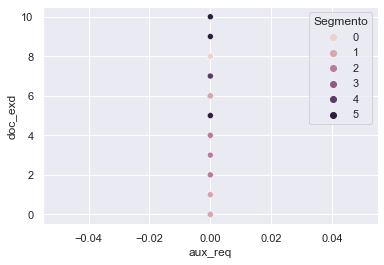

In [47]:
sns.scatterplot(x="aux_req", y="doc_exd", hue="Segmento",data=df_primaria_knn)

<AxesSubplot:xlabel='Docentes de aula', ylabel='doc_exd'>

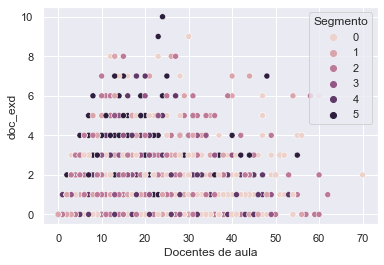

In [52]:
sns.scatterplot(x="Docentes de aula", y="doc_exd", hue="Segmento",data=df_primaria_knn)

In [46]:
df_primaria_knn.columns.to_list()

['dir_n',
 'dir_c',
 'sub_dir_n',
 'sub_dir_c',
 'jer_n',
 'jer_c',
 'doc_aula_n',
 'doc_aula_c',
 'otro_doc_n',
 'otro_doc_c',
 'aux_n',
 'aux_c',
 'cant1 (t)',
 'cant2 (t)',
 'cant3 (t)',
 'cant4 (t)',
 'cant5 (t)',
 'cant6 (t)',
 'inclu1 (t)',
 'inclu2 (t)',
 'inclu3 (t)',
 'inclu4 (t)',
 'inclu5 (t)',
 'inclu6 (t)',
 'cant1 (t-4)',
 'cant2 (t-4)',
 'cant3 (t-4)',
 'cant4 (t-4)',
 'cant5 (t-4)',
 'cant6 (t-4)',
 'inclu1 (t-4)',
 'inclu2 (t-4)',
 'inclu3 (t-4)',
 'inclu4 (t-4)',
 'inclu5 (t-4)',
 'inclu6 (t-4)',
 'cant1 (t-3)',
 'cant2 (t-3)',
 'cant3 (t-3)',
 'cant4 (t-3)',
 'cant5 (t-3)',
 'cant6 (t-3)',
 'inclu1 (t-3)',
 'inclu2 (t-3)',
 'inclu3 (t-3)',
 'inclu4 (t-3)',
 'inclu5 (t-3)',
 'inclu6 (t-3)',
 'cant1 (t-2)',
 'cant2 (t-2)',
 'cant3 (t-2)',
 'cant4 (t-2)',
 'cant5 (t-2)',
 'cant6 (t-2)',
 'inclu1 (t-2)',
 'inclu2 (t-2)',
 'inclu3 (t-2)',
 'inclu4 (t-2)',
 'inclu5 (t-2)',
 'inclu6 (t-2)',
 'cant1 (t-1)',
 'cant2 (t-1)',
 'cant3 (t-1)',
 'cant4 (t-1)',
 'cant5 (t-1)',
 'ca

<AxesSubplot:xlabel='Segmento', ylabel='tasa_c_anual_regular'>

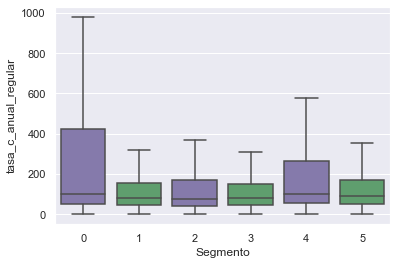

In [36]:
sns.boxplot(x='Segmento', y='tasa_c_anual_regular', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)

In [ ]:
sns.boxplot(x='Segmento', y='tasa_c_anual_regular', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)

<AxesSubplot:xlabel='doc_aula_req', ylabel='Docentes de aula'>

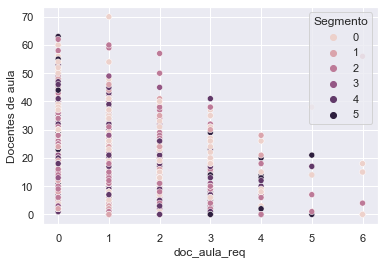

In [42]:
sns.scatterplot(x="doc_aula_req", y="Docentes de aula",
                hue="Segmento",data=df_primaria_knn)

<AxesSubplot:xlabel='doc_aula_req', ylabel='Docentes de aula'>

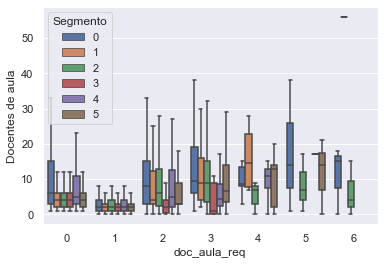

In [40]:
sns.boxplot(x='doc_aula_req', y='Docentes de aula', hue='Segmento',
            data=df_primaria_knn,showfliers = False)

<AxesSubplot:xlabel='Segmento', ylabel='Docentes de aula'>

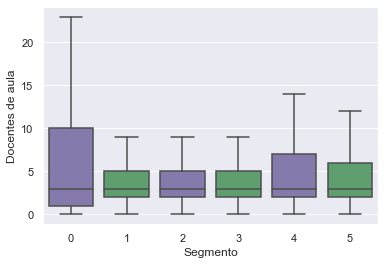

In [27]:
sns.boxplot(x='Segmento', y='Docentes de aula', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)

<AxesSubplot:xlabel='Segmento', ylabel='doc_aula_req'>

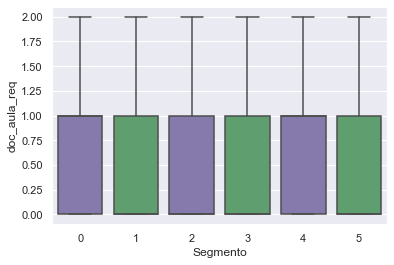

In [28]:
sns.boxplot(x='Segmento', y='doc_aula_req', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)

<AxesSubplot:xlabel='Segmento', ylabel='tasa_c_anual_regular'>

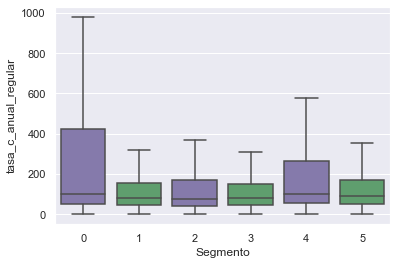

In [29]:
sns.boxplot(x='Segmento', y='tasa_c_anual_regular', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)

<AxesSubplot:xlabel='Segmento', ylabel='doc_exd'>

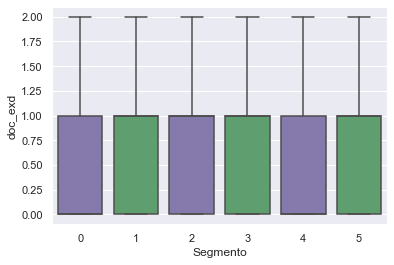

In [35]:
sns.boxplot(x='Segmento', y='doc_exd', palette=["m", "g"],
            data=df_primaria_knn,showfliers = False)


In [53]:
for i in range(7):
    print(f'Cluster numero {i}')
    print((df_primaria_knn.loc[df_primaria_knn['Segmento']==i,['ruralidad_Rural 1','ruralidad_Rural 2','ruralidad_Rural 3','vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue']].describe().transpose()))



Cluster numero 0
                    count      mean       std  min  25%  50%  75%  max
ruralidad_Rural 1  3344.0  0.508373  0.500005  0.0  0.0  1.0  1.0  1.0
ruralidad_Rural 2  3344.0  0.124701  0.330429  0.0  0.0  0.0  0.0  1.0
ruralidad_Rural 3  3344.0  0.050837  0.219698  0.0  0.0  0.0  0.0  1.0
vraem_Vraem        3344.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
frontera_Frontera  3344.0  0.143242  0.350371  0.0  0.0  0.0  0.0  1.0
bilingue_Bilingue  3344.0  0.187799  0.390610  0.0  0.0  0.0  0.0  1.0
Cluster numero 1
                    count      mean       std  min  25%  50%  75%  max
ruralidad_Rural 1  4079.0  0.396421  0.489214  0.0  0.0  0.0  1.0  1.0
ruralidad_Rural 2  4079.0  0.320912  0.466884  0.0  0.0  0.0  1.0  1.0
ruralidad_Rural 3  4079.0  0.121108  0.326293  0.0  0.0  0.0  0.0  1.0
vraem_Vraem        4079.0  0.066928  0.249928  0.0  0.0  0.0  0.0  1.0
frontera_Frontera  4079.0  0.029909  0.170358  0.0  0.0  0.0  0.0  1.0
bilingue_Bilingue  4079.0  0.152979  0.3600

In [33]:
for i in range(7):
    print(f'Cluster numero {i}')
    print((df_primaria_knn.loc[df_primaria_knn['Segmento']==i,['doc_exd','doc_aula_req']].describe().transpose()))


Cluster numero 0
               count      mean       std  min  25%  50%  75%  max
doc_exd       3344.0  0.607656  0.899903  0.0  0.0  0.0  1.0  9.0
doc_aula_req  3344.0  0.644438  0.671241  0.0  0.0  1.0  1.0  6.0
Cluster numero 1
               count      mean       std  min  25%  50%  75%  max
doc_exd       4079.0  0.871537  0.821589  0.0  0.0  1.0  1.0  8.0
doc_aula_req  4079.0  0.341996  0.536531  0.0  0.0  0.0  1.0  6.0
Cluster numero 2
               count      mean       std  min  25%  50%  75%  max
doc_exd       6268.0  0.732770  0.888681  0.0  0.0  1.0  1.0  8.0
doc_aula_req  6268.0  0.518826  0.627641  0.0  0.0  0.0  1.0  6.0
Cluster numero 3
               count      mean       std  min  25%  50%  75%  max
doc_exd       2920.0  0.912329  0.775515  0.0  0.0  1.0  1.0  7.0
doc_aula_req  2920.0  0.304452  0.507005  0.0  0.0  0.0  1.0  3.0
Cluster numero 4
               count      mean       std  min  25%  50%  75%  max
doc_exd       2917.0  0.589304  0.836821  0.0  0.0  0.0  

In [56]:
for i in range(7):
    print(f'Cluster numero {i}')
    print((df_primaria_knn.loc[df_primaria_knn['Segmento']==i,personal]).describe().transpose())

Cluster numero 0
                    count      mean       std  min  25%  50%  75%   max
Directores        11070.0  0.210930  0.407988  0.0  0.0  0.0  0.0   1.0
Subdirectores     11070.0  0.030081  0.197322  0.0  0.0  0.0  0.0   3.0
Jerarquicos       11070.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Docentes de aula  11070.0  3.405601  4.596236  0.0  1.0  2.0  4.0  51.0
Otros docentes    11070.0  0.227371  0.732103  0.0  0.0  0.0  0.0   8.0
Auxiliares        11070.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Cluster numero 1
                    count      mean       std  min  25%  50%  75%   max
Directores        13292.0  0.289497  0.453712  0.0  0.0  0.0  1.0   2.0
Subdirectores     13292.0  0.077265  0.333206  0.0  0.0  0.0  0.0   6.0
Jerarquicos       13292.0  0.000226  0.015022  0.0  0.0  0.0  0.0   1.0
Docentes de aula  13292.0  4.715242  6.888840  0.0  1.0  2.0  5.0  70.0
Otros docentes    13292.0  0.380530  0.990637  0.0  0.0  0.0  0.0   8.0
Auxiliares        13292.0  0.0

In [80]:
df_primaria_knn['Segmento'] = clusters

In [82]:
# Caraterizar los clusters
df_primaria_knn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dir_n,87339.0,0.174825,0.379819,0.0,0.0,0.000000,0.0,1.000000
dir_c,87339.0,0.061290,0.239863,0.0,0.0,0.000000,0.0,1.000000
sub_dir_n,87339.0,0.040669,0.201142,0.0,0.0,0.000000,0.0,2.000000
sub_dir_c,87339.0,0.021869,0.169398,0.0,0.0,0.000000,0.0,5.000000
jer_n,87339.0,0.000023,0.004785,0.0,0.0,0.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...
Matricula inclusiva total t-3,87339.0,1.389734,3.250640,0.0,0.0,0.000000,1.0,86.000000
Matricula regular total t-4,87339.0,85.262930,162.811232,0.0,13.0,30.000000,71.0,1961.000000
Matricula inclusiva total t-4,87339.0,1.403176,3.268476,0.0,0.0,0.000000,1.0,86.000000
tasa_c_anual_regular,87339.0,175.744955,342.326580,0.0,25.0,56.666667,139.0,4440.666667


In [81]:
df_primaria_knn[personal].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Directores,87339.0,0.236114,0.424965,0.0,0.0,0.0,0.0,2.0
Subdirectores,87339.0,0.062538,0.287886,0.0,0.0,0.0,0.0,6.0
Jerarquicos,87339.0,0.000137,0.011721,0.0,0.0,0.0,0.0,1.0
Docentes de aula,87339.0,4.302912,6.313760,0.0,1.0,2.0,4.0,80.0
Otros docentes,87339.0,0.333608,0.934679,0.0,0.0,0.0,0.0,12.0
Auxiliares,87339.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
['dir_n','dir_c','sub_dir_n','sub_dir_c','jer_n', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c','aux_n','aux_c']
['secciones_necesarias','doc_aula_req','aux_req', 'aux_exd']
['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

['Matricula regular total t', 'Matricula inclusiva total t',
 'Matricula regular total t-1','Matricula inclusiva total t-1',
 'Matricula regular total t-2','Matricula inclusiva total t-2',
 'Matricula regular total t-3','Matricula inclusiva total t-3',
 'Matricula regular total t-4','Matricula inclusiva total t-4',
 'tasa_c_anual_regular']

['ruralidad_Rural 1','ruralidad_Rural 2','ruralidad_Rural 3','vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue']
